In [139]:
from sympy import *
from dtumathtools import *
from IPython.display import Markdown
import networkx as nx
init_printing(use_latex="mathjax")
mdisplay = lambda x: display(Markdown(str(x)))
nx_args={'with_labels':True, 'node_color':"white", 'edgecolors':"black", 'node_size':400}

def cprint(input):
    output = ""
    if type(input) == list:
        for i in input:
            output += f"{input}\n\n"
    else:
        output += f"{input}\n\n"
    return output

# Grafteoretisk Modellering af Netværk

## Opgave 1

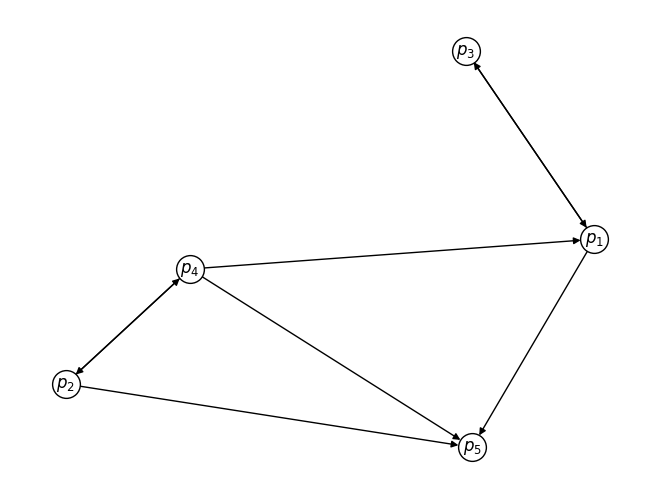

In [140]:
p1,p2,p3,p4,p5 = symbols('$p_1:6$')
V1 = {p1, p2, p3, p4, p5}
E1 = {(p1,p3), (p1,p5),(p2,p4),(p2,p5),(p3,p1),(p4,p1),(p4,p2),(p4,p5)}
W = nx.DiGraph()
W.add_nodes_from(V1, color="white")

W.add_edges_from(E1)
nx.draw(W,**nx_args)

## Opgave 2

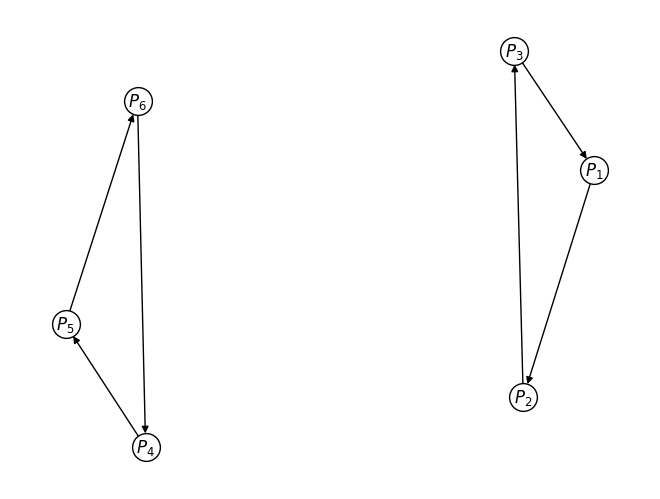

In [141]:
p1,p2,p3,p4,p5,p6 = symbols('$P_1:7$')
V2 = {p1, p2, p3, p4, p5, p6}
E2 = {(p1,p2), (p2,p3),(p3,p1),(p4,p5),(p5,p6),(p6,p4)}
W2 = nx.DiGraph()
W2.add_nodes_from(V2, color="white")

W2.add_edges_from(E2)
nx.draw(W2,**nx_args)

# Opgave 3
#

Jo flere komponenter der er i et netværk, jo svære bliver det at finde en specifik node. Faktisk er det helt umuligt at finde frem til en node i et komponent, hvis man er i et andet komponent til at begynde med. Der er altså ingen links fra den ene hjemmeside til den anden. 

##

In [142]:
W1 = {p1: {p3, p5}, p2: {p5, p4}, p3: {p1}, p4: {p1, p5, p2}, p5: {}}
W2 = {p1: {p2}, p2: {p3}, p3: {p1}, p4: {p5}, p5: {p6}, p6: {p4}}

Det kan tjekkes om en node i graphen ikke linker til andrer noder, ved at tjekke om nodens value i adjacency listen er den tomme mængde $\emptyset$

## Opgave 5

In [143]:
import numpy as np

# Input: n og k er ikke-negative heltal
# Output: web er en dictionary med n nøgler.
# Værdien af hver nøgle er en liste, der er en delmængde af nøglerne.
def make_web(n,k,kmin=0):
    assert(k < n), "k skal være mindre end n (da man ikke kan linke til sig selv)"
    assert(kmin <= k), "kmin skal være mindre end eller lig med k"
    keys = list(symbols(f"$p_0:{n}$")) 
    web = dict()
    
    for j in keys:
        numlinks = np.random.randint(kmin, k)
        key_choices = keys.copy()
        key_choices.remove(j)
        web[j] = set(np.random.choice(key_choices, numlinks))
    
    return web

print(make_web(4,3, 1))

{$p_0$: {$p_3$}, $p_1$: {$p_3$, $p_0$}, $p_2$: {$p_1$}, $p_3$: {$p_1$}}



## Opgave 6


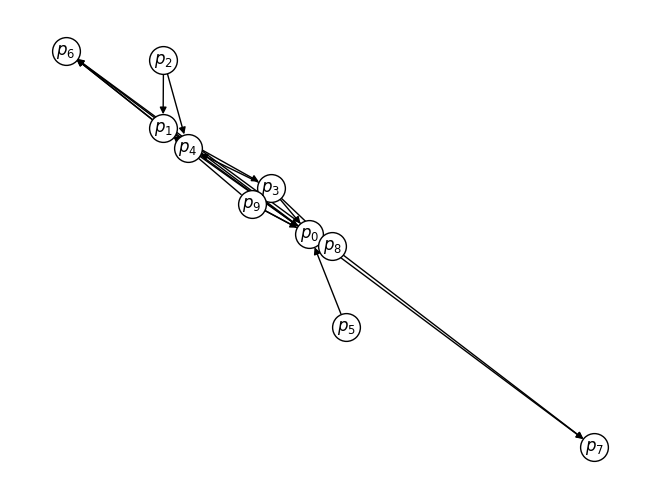

In [144]:
import matplotlib.pyplot as plt

def convert_to_nxgraph(web : dict):
    digraph = nx.DiGraph()
    digraph.add_nodes_from(web.keys())

    for page in web.keys():
        for link_to in web[page]:
            digraph.add_edge(page, link_to)

    return digraph

    # Input: netværk som dictionary
    # Output: Netværk visualiseret som graf
def visualize_graph(web : dict):
    
    digraph = convert_to_nxgraph(web)
    
    plt.figure()
    nx.draw(digraph, **nx_args)
    plt.plot()

visualize_graph(make_web(10, 5, 0))

# Link matricen og Random Surfer Modellen

## Opgave 7

In [145]:
def make_adjacency_matrix(graph):
    A = nx.adjacency_matrix(convert_to_nxgraph(graph))
    b = A.toarray().transpose()
    return b

In [146]:
W1 = {p1: {p3, p5}, p2: {p5, p4}, p3: {p1}, p4: {p1, p5, p2}, p5: {}}
display(Matrix(make_adjacency_matrix(W1)))




⎡0  0  1  1  0⎤
⎢             ⎥
⎢0  0  0  1  0⎥
⎢             ⎥
⎢1  0  0  0  0⎥
⎢             ⎥
⎢0  1  0  0  0⎥
⎢             ⎥
⎣1  1  0  1  0⎦

# Opgave 8

In [162]:
def make_link_matrix(graph: dict):

    adjacency_matrix : np.ndarray = make_adjacency_matrix(graph)

    n = adjacency_matrix.shape[0]
    link_matrix = np.zeros((n,n))
    
    for j in range(n):
        N = adjacency_matrix[:,j].sum()
        
        if N == 0:
            link_matrix[:,j] = 1 / n
            continue
            
        for i in range(n):
            if adjacency_matrix[i][j] == 1:
                link_matrix[i][j] = 1 / N
    
    return link_matrix
                

display(Matrix(make_link_matrix(W1)))


⎡0.0  0.0  1.0  0.333333333333333  0.2⎤
⎢                                     ⎥
⎢0.0  0.0  0.0  0.333333333333333  0.2⎥
⎢                                     ⎥
⎢0.5  0.0  0.0         0.0         0.2⎥
⎢                                     ⎥
⎢0.0  0.5  0.0         0.0         0.2⎥
⎢                                     ⎥
⎣0.5  0.5  0.0  0.333333333333333  0.2⎦

Matricerne har elementer samme sted, man tager antal 1-taller i hver søjle og sætter de tilsvarende elementer lig 1 / dette antal.
Hvis en søjle er en 0 vektor, sætter man alle elementer lig $\frac1N$

## Opgave 9

In [148]:
# Input: Et netværk som dictionary og en start side
# Output: Sandsynlighedsfordeling som dictionary for næste hjemmeside
def surf_step(web, page):
    
    distribution=dict()

    for link in web[page]:
        distribution[link] = 1 / len(web[page])
        
    if len(distribution) == 0:
        num_pages = len(web.keys())
        
        for web_page in web.keys():
            distribution[web_page] = 1 / num_pages

    return distribution

print(surf_step(W1, p1))

{$P_3$: 0.5, $P_5$: 0.5}


## Opgave 10

In [149]:
# Input: Et netværk som dictionary og antallet af skridt i random surf simuleringen
# Output: PageRank-værdier for hver side som en dictionary
def random_surf(web, n):


    
    ranking=dict()
    for page in web.keys():
        ranking[page] = 0
    page = np.random.choice(list(web.keys()))
    ranking[page] = 1
    
    
    for i in range(n-1):
        potential_pages = surf_step(web, page)
        page = np.random.choice(list(potential_pages.keys()), p = list(potential_pages.values()))
        ranking[page] += 1 
    for page in web.keys():
        ranking[page] /= n 
    return ranking
print(random_surf(W1,1000))

{$P_1$: 0.306, $P_2$: 0.095, $P_3$: 0.21, $P_4$: 0.108, $P_5$: 0.281}


## Opgave 11

In [150]:
def test_surf_model(model: callable, web: dict):
    output = ""
    for interval in [100, 1000, 10000]:
        output += cprint(f"interval: {interval}")
        for n in range(interval, interval+10, 1):
            output += cprint(model(web, n))
    return output


In [151]:
output = ""
output += cprint(test_surf_model(random_surf, W1))
output += cprint(test_surf_model(random_surf, W2))
mdisplay(output)

interval: 100

{$P_1$: 0.35, $P_2$: 0.07, $P_3$: 0.24, $P_4$: 0.06, $P_5$: 0.28}

{$P_1$: 0.26732673267326734, $P_2$: 0.1188118811881188, $P_3$: 0.18811881188118812, $P_4$: 0.09900990099009901, $P_5$: 0.32673267326732675}

{$P_1$: 0.3333333333333333, $P_2$: 0.0784313725490196, $P_3$: 0.23529411764705882, $P_4$: 0.0784313725490196, $P_5$: 0.27450980392156865}

{$P_1$: 0.27184466019417475, $P_2$: 0.10679611650485436, $P_3$: 0.17475728155339806, $P_4$: 0.1262135922330097, $P_5$: 0.32038834951456313}

{$P_1$: 0.2980769230769231, $P_2$: 0.09615384615384616, $P_3$: 0.19230769230769232, $P_4$: 0.09615384615384616, $P_5$: 0.3173076923076923}

{$P_1$: 0.3619047619047619, $P_2$: 0.047619047619047616, $P_3$: 0.2761904761904762, $P_4$: 0.06666666666666667, $P_5$: 0.24761904761904763}

{$P_1$: 0.33962264150943394, $P_2$: 0.05660377358490566, $P_3$: 0.2358490566037736, $P_4$: 0.08490566037735849, $P_5$: 0.2830188679245283}

{$P_1$: 0.308411214953271, $P_2$: 0.07476635514018691, $P_3$: 0.21495327102803738, $P_4$: 0.08411214953271028, $P_5$: 0.3177570093457944}

{$P_1$: 0.28703703703703703, $P_2$: 0.10185185185185185, $P_3$: 0.18518518518518517, $P_4$: 0.1388888888888889, $P_5$: 0.28703703703703703}

{$P_1$: 0.3486238532110092, $P_2$: 0.045871559633027525, $P_3$: 0.23853211009174313, $P_4$: 0.07339449541284404, $P_5$: 0.29357798165137616}

interval: 1000

{$P_1$: 0.32, $P_2$: 0.083, $P_3$: 0.235, $P_4$: 0.103, $P_5$: 0.259}

{$P_1$: 0.3176823176823177, $P_2$: 0.07392607392607392, $P_3$: 0.23476523476523475, $P_4$: 0.08091908091908091, $P_5$: 0.29270729270729273}

{$P_1$: 0.3013972055888224, $P_2$: 0.07984031936127745, $P_3$: 0.2085828343313373, $P_4$: 0.10379241516966067, $P_5$: 0.3063872255489022}

{$P_1$: 0.29910269192422734, $P_2$: 0.09571286141575275, $P_3$: 0.2123629112662014, $P_4$: 0.1016949152542373, $P_5$: 0.29112662013958124}

{$P_1$: 0.3147410358565737, $P_2$: 0.08864541832669323, $P_3$: 0.22111553784860558, $P_4$: 0.10258964143426295, $P_5$: 0.2729083665338645}

{$P_1$: 0.28059701492537314, $P_2$: 0.10845771144278607, $P_3$: 0.19601990049751244, $P_4$: 0.11840796019900497, $P_5$: 0.2965174129353234}

{$P_1$: 0.2783300198807157, $P_2$: 0.11232604373757456, $P_3$: 0.2047713717693837, $P_4$: 0.10834990059642147, $P_5$: 0.2962226640159046}

{$P_1$: 0.2840119165839126, $P_2$: 0.10724925521350546, $P_3$: 0.19761668321747766, $P_4$: 0.10824230387288977, $P_5$: 0.3028798411122145}

{$P_1$: 0.3005952380952381, $P_2$: 0.09424603174603174, $P_3$: 0.2123015873015873, $P_4$: 0.10317460317460317, $P_5$: 0.2896825396825397}

{$P_1$: 0.30426164519326065, $P_2$: 0.08919722497522299, $P_3$: 0.21010901883052527, $P_4$: 0.10307234886025768, $P_5$: 0.2933597621407334}

interval: 10000

{$P_1$: 0.3069, $P_2$: 0.0906, $P_3$: 0.2143, $P_4$: 0.1032, $P_5$: 0.285}

{$P_1$: 0.30016998300169984, $P_2$: 0.09429057094290572, $P_3$: 0.20937906209379062, $P_4$: 0.10788921107889211, $P_5$: 0.2882711728827117}

{$P_1$: 0.3047390521895621, $P_2$: 0.09028194361127774, $P_3$: 0.21445710857828434, $P_4$: 0.10307938412317537, $P_5$: 0.28744251149770045}

{$P_1$: 0.3083075077476757, $P_2$: 0.08817354793561931, $P_3$: 0.21673497950614815, $P_4$: 0.10066979906028191, $P_5$: 0.28611416575027493}

{$P_1$: 0.2999800079968013, $P_2$: 0.09466213514594163, $P_3$: 0.20841663334666133, $P_4$: 0.10235905637744902, $P_5$: 0.2945821671331467}

{$P_1$: 0.3071464267866067, $P_2$: 0.09345327336331834, $P_3$: 0.2143928035982009, $P_4$: 0.10384807596201899, $P_5$: 0.2811594202898551}

{$P_1$: 0.30361782930241854, $P_2$: 0.09114531281231261, $P_3$: 0.21267239656206277, $P_4$: 0.10303817709374376, $P_5$: 0.2895262842294623}

{$P_1$: 0.30238832817028083, $P_2$: 0.0945338263215749, $P_3$: 0.20895373238732887, $P_4$: 0.10422704107125012, $P_5$: 0.28989707204956533}

{$P_1$: 0.3055555555555556, $P_2$: 0.09022781774580335, $P_3$: 0.2107314148681055, $P_4$: 0.10141886490807354, $P_5$: 0.29206634692246203}

{$P_1$: 0.30512538715156357, $P_2$: 0.09271655510040963, $P_3$: 0.20891197921870316, $P_4$: 0.10430612448796084, $P_5$: 0.2889399540413628}



interval: 100

{$P_1$: 0.33, $P_2$: 0.33, $P_3$: 0.34, $P_4$: 0.0, $P_5$: 0.0, $P_6$: 0.0}

{$P_1$: 0.0, $P_2$: 0.0, $P_3$: 0.0, $P_4$: 0.33663366336633666, $P_5$: 0.32673267326732675, $P_6$: 0.33663366336633666}

{$P_1$: 0.3333333333333333, $P_2$: 0.3333333333333333, $P_3$: 0.3333333333333333, $P_4$: 0.0, $P_5$: 0.0, $P_6$: 0.0}

{$P_1$: 0.33980582524271846, $P_2$: 0.3300970873786408, $P_3$: 0.3300970873786408, $P_4$: 0.0, $P_5$: 0.0, $P_6$: 0.0}

{$P_1$: 0.33653846153846156, $P_2$: 0.3269230769230769, $P_3$: 0.33653846153846156, $P_4$: 0.0, $P_5$: 0.0, $P_6$: 0.0}

{$P_1$: 0.0, $P_2$: 0.0, $P_3$: 0.0, $P_4$: 0.3333333333333333, $P_5$: 0.3333333333333333, $P_6$: 0.3333333333333333}

{$P_1$: 0.330188679245283, $P_2$: 0.330188679245283, $P_3$: 0.33962264150943394, $P_4$: 0.0, $P_5$: 0.0, $P_6$: 0.0}

{$P_1$: 0.32710280373831774, $P_2$: 0.3364485981308411, $P_3$: 0.3364485981308411, $P_4$: 0.0, $P_5$: 0.0, $P_6$: 0.0}

{$P_1$: 0.0, $P_2$: 0.0, $P_3$: 0.0, $P_4$: 0.3333333333333333, $P_5$: 0.3333333333333333, $P_6$: 0.3333333333333333}

{$P_1$: 0.0, $P_2$: 0.0, $P_3$: 0.0, $P_4$: 0.3394495412844037, $P_5$: 0.3302752293577982, $P_6$: 0.3302752293577982}

interval: 1000

{$P_1$: 0.333, $P_2$: 0.334, $P_3$: 0.333, $P_4$: 0.0, $P_5$: 0.0, $P_6$: 0.0}

{$P_1$: 0.0, $P_2$: 0.0, $P_3$: 0.0, $P_4$: 0.3336663336663337, $P_5$: 0.33266733266733267, $P_6$: 0.3336663336663337}

{$P_1$: 0.3333333333333333, $P_2$: 0.3333333333333333, $P_3$: 0.3333333333333333, $P_4$: 0.0, $P_5$: 0.0, $P_6$: 0.0}

{$P_1$: 0.0, $P_2$: 0.0, $P_3$: 0.0, $P_4$: 0.33300099700897307, $P_5$: 0.3339980059820538, $P_6$: 0.33300099700897307}

{$P_1$: 0.0, $P_2$: 0.0, $P_3$: 0.0, $P_4$: 0.3336653386454183, $P_5$: 0.33266932270916333, $P_6$: 0.3336653386454183}

{$P_1$: 0.3333333333333333, $P_2$: 0.3333333333333333, $P_3$: 0.3333333333333333, $P_4$: 0.0, $P_5$: 0.0, $P_6$: 0.0}

{$P_1$: 0.33300198807157055, $P_2$: 0.33300198807157055, $P_3$: 0.33399602385685884, $P_4$: 0.0, $P_5$: 0.0, $P_6$: 0.0}

{$P_1$: 0.0, $P_2$: 0.0, $P_3$: 0.0, $P_4$: 0.3336643495531281, $P_5$: 0.3326713008937438, $P_6$: 0.3336643495531281}

{$P_1$: 0.0, $P_2$: 0.0, $P_3$: 0.0, $P_4$: 0.3333333333333333, $P_5$: 0.3333333333333333, $P_6$: 0.3333333333333333}

{$P_1$: 0.0, $P_2$: 0.0, $P_3$: 0.0, $P_4$: 0.3330029732408325, $P_5$: 0.333994053518335, $P_6$: 0.3330029732408325}

interval: 10000

{$P_1$: 0.0, $P_2$: 0.0, $P_3$: 0.0, $P_4$: 0.3334, $P_5$: 0.3333, $P_6$: 0.3333}

{$P_1$: 0.0, $P_2$: 0.0, $P_3$: 0.0, $P_4$: 0.33326667333266674, $P_5$: 0.33336666333366666, $P_6$: 0.33336666333366666}

{$P_1$: 0.3333333333333333, $P_2$: 0.3333333333333333, $P_3$: 0.3333333333333333, $P_4$: 0.0, $P_5$: 0.0, $P_6$: 0.0}

{$P_1$: 0.0, $P_2$: 0.0, $P_3$: 0.0, $P_4$: 0.3333000099970009, $P_5$: 0.3333000099970009, $P_6$: 0.3333999800059982}

{$P_1$: 0.33336665333866455, $P_2$: 0.33336665333866455, $P_3$: 0.33326669332267095, $P_4$: 0.0, $P_5$: 0.0, $P_6$: 0.0}

{$P_1$: 0.3333333333333333, $P_2$: 0.3333333333333333, $P_3$: 0.3333333333333333, $P_4$: 0.0, $P_5$: 0.0, $P_6$: 0.0}

{$P_1$: 0.3333000199880072, $P_2$: 0.3333000199880072, $P_3$: 0.3333999600239856, $P_4$: 0.0, $P_5$: 0.0, $P_6$: 0.0}

{$P_1$: 0.3332667133006895, $P_2$: 0.33336664334965527, $P_3$: 0.33336664334965527, $P_4$: 0.0, $P_5$: 0.0, $P_6$: 0.0}

{$P_1$: 0.0, $P_2$: 0.0, $P_3$: 0.0, $P_4$: 0.3333333333333333, $P_5$: 0.3333333333333333, $P_6$: 0.3333333333333333}

{$P_1$: 0.0, $P_2$: 0.0, $P_3$: 0.0, $P_4$: 0.33339994005395146, $P_5$: 0.33330002997302427, $P_6$: 0.33330002997302427}





Den varierer meget, selv små skridt i iterations størrelsen varierer ret meget.
Størrelsesordnerne er dog ca. det samme, og den bliver mere konsistent desto højere skridt iterations størrelsen er.

## Opgave 12


In [152]:
import random

# Input: Et netværk som dictionary og en start side
# Output: Sandsynlighedsfordeling som dictionary for næste hjemmeside
def surf_step_damp(web, page, d):
    
    distribution=dict()

    for link in web[page]:
        distribution[link] = 1 / len(web[page])
    
    if len(distribution) == 0 or random.random() >= d:
        num_pages = len(web.keys())
        
        for web_page in web.keys():
            distribution[web_page] = 1 / num_pages

    return distribution

print(surf_step_damp(W1, p1, 0.85))

{$P_3$: 0.5, $P_5$: 0.5}


In [153]:
def random_surf_damp(web, n, d):


    
    ranking=dict()
    for page in web.keys():
        ranking[page] = 0
    page = np.random.choice(list(web.keys()))
    ranking[page] = 1
    
    
    for i in range(n-1):
        potential_pages = surf_step_damp(web, page, d)
        page = np.random.choice(list(potential_pages.keys()), p = list(potential_pages.values()))
        ranking[page] += 1 
    for page in web.keys():
        ranking[page] /= n 
    return ranking
print(random_surf_damp(W1,1000, 0.85))

{$P_1$: 0.271, $P_2$: 0.112, $P_3$: 0.197, $P_4$: 0.14, $P_5$: 0.28}


# Opgave 13

In [154]:
dampening_factor = 0.85
output = ""
output += cprint(test_surf_model(lambda web, n: random_surf_damp(web, n, dampening_factor), W1))
# output += cprint(test_surf_model(lambda web, n: random_surf_damp(web, n, dampening_factor), W2))
mdisplay(output)

interval: 100

{$P_1$: 0.23, $P_2$: 0.14, $P_3$: 0.16, $P_4$: 0.17, $P_5$: 0.3}

{$P_1$: 0.2871287128712871, $P_2$: 0.09900990099009901, $P_3$: 0.24752475247524752, $P_4$: 0.0891089108910891, $P_5$: 0.27722772277227725}

{$P_1$: 0.30392156862745096, $P_2$: 0.09803921568627451, $P_3$: 0.24509803921568626, $P_4$: 0.09803921568627451, $P_5$: 0.2549019607843137}

{$P_1$: 0.2621359223300971, $P_2$: 0.14563106796116504, $P_3$: 0.1650485436893204, $P_4$: 0.1650485436893204, $P_5$: 0.2621359223300971}

{$P_1$: 0.3269230769230769, $P_2$: 0.08653846153846154, $P_3$: 0.20192307692307693, $P_4$: 0.11538461538461539, $P_5$: 0.2692307692307692}

{$P_1$: 0.3142857142857143, $P_2$: 0.09523809523809523, $P_3$: 0.23809523809523808, $P_4$: 0.08571428571428572, $P_5$: 0.26666666666666666}

{$P_1$: 0.3113207547169811, $P_2$: 0.09433962264150944, $P_3$: 0.22641509433962265, $P_4$: 0.1320754716981132, $P_5$: 0.2358490566037736}

{$P_1$: 0.2803738317757009, $P_2$: 0.1308411214953271, $P_3$: 0.21495327102803738, $P_4$: 0.12149532710280374, $P_5$: 0.2523364485981308}

{$P_1$: 0.2962962962962963, $P_2$: 0.12962962962962962, $P_3$: 0.2037037037037037, $P_4$: 0.1111111111111111, $P_5$: 0.25925925925925924}

{$P_1$: 0.25688073394495414, $P_2$: 0.10091743119266056, $P_3$: 0.26605504587155965, $P_4$: 0.11009174311926606, $P_5$: 0.26605504587155965}

interval: 1000

{$P_1$: 0.291, $P_2$: 0.104, $P_3$: 0.202, $P_4$: 0.126, $P_5$: 0.277}

{$P_1$: 0.2977022977022977, $P_2$: 0.0979020979020979, $P_3$: 0.21478521478521478, $P_4$: 0.11888111888111888, $P_5$: 0.2707292707292707}

{$P_1$: 0.27045908183632733, $P_2$: 0.10978043912175649, $P_3$: 0.20059880239520958, $P_4$: 0.12674650698602793, $P_5$: 0.29241516966067865}

{$P_1$: 0.2931206380857428, $P_2$: 0.10468594217347957, $P_3$: 0.21036889332003988, $P_4$: 0.09371884346959122, $P_5$: 0.29810568295114653}

{$P_1$: 0.28286852589641437, $P_2$: 0.10756972111553785, $P_3$: 0.20318725099601595, $P_4$: 0.12151394422310757, $P_5$: 0.2848605577689243}

{$P_1$: 0.27761194029850744, $P_2$: 0.12139303482587065, $P_3$: 0.1900497512437811, $P_4$: 0.12935323383084577, $P_5$: 0.281592039800995}

{$P_1$: 0.28926441351888665, $P_2$: 0.1143141153081511, $P_3$: 0.20576540755467196, $P_4$: 0.1143141153081511, $P_5$: 0.27634194831013914}

{$P_1$: 0.26911618669314796, $P_2$: 0.12711022840119166, $P_3$: 0.18371400198609733, $P_4$: 0.12413108242303873, $P_5$: 0.2959285004965243}

{$P_1$: 0.2619047619047619, $P_2$: 0.13392857142857142, $P_3$: 0.1765873015873016, $P_4$: 0.12996031746031747, $P_5$: 0.2976190476190476}

{$P_1$: 0.288404360753221, $P_2$: 0.11000991080277503, $P_3$: 0.19722497522299307, $P_4$: 0.12487611496531219, $P_5$: 0.2794846382556987}

interval: 10000

{$P_1$: 0.279, $P_2$: 0.1156, $P_3$: 0.1989, $P_4$: 0.128, $P_5$: 0.2785}

{$P_1$: 0.28017198280171984, $P_2$: 0.11708829117088292, $P_3$: 0.20327967203279673, $P_4$: 0.12318768123187682, $P_5$: 0.2762723727627237}

{$P_1$: 0.29194161167766447, $P_2$: 0.10727854429114177, $P_3$: 0.20805838832233553, $P_4$: 0.1240751849630074, $P_5$: 0.26864627074585085}

{$P_1$: 0.28071578526442065, $P_2$: 0.11416575027491753, $P_3$: 0.1979406178146556, $P_4$: 0.12446266120163951, $P_5$: 0.2827151854443667}

{$P_1$: 0.27978808476609357, $P_2$: 0.11065573770491803, $P_3$: 0.1988204718112755, $P_4$: 0.124750099960016, $P_5$: 0.28598560575769694}

{$P_1$: 0.2748625687156422, $P_2$: 0.11484257871064468, $P_3$: 0.19430284857571214, $P_4$: 0.1266366816591704, $P_5$: 0.2893553223388306}

{$P_1$: 0.2762342594443334, $P_2$: 0.11912852288626824, $P_3$: 0.1943833699780132, $P_4$: 0.13312012792324604, $P_5$: 0.2771337197681391}

{$P_1$: 0.28130308783851304, $P_2$: 0.11292095533126811, $P_3$: 0.1956630358748876, $P_4$: 0.12621165184370942, $P_5$: 0.2839012691116219}

{$P_1$: 0.2806754596322942, $P_2$: 0.11410871302957634, $P_3$: 0.1950439648281375, $P_4$: 0.1254996003197442, $P_5$: 0.2846722621902478}

{$P_1$: 0.27854930562493757, $P_2$: 0.11729443500849236, $P_3$: 0.19672294934558898, $P_4$: 0.1281846338295534, $P_5$: 0.27924867619142774}





Nu kan man se at man får et bedere estimat på pageranken for grafer med flere komponenter.

# Rekursiv Model og Matrix Formulering

## Opgave 14

\begin{equation*}
PR_{n+1}(p) = (1-d)\frac{1}{N} + d\sum_{q \in Inbound(p)}\frac{PR_n(q)}{\deg^+(q)} + \left[ d\sum_{s \in Sinks(W)}\frac{PR_{n}(s)}{N} \right]
\end{equation*}

Første led er sandsynligheden af at man kommer fra en tilfældig hjemmeside, hvor (1-d) er sandsynlighed for at dæmpningen sker. 1/N er sandsynlighen for at P sker. 
Andet led er sandsynlighedn for at man kommer (direkte) fra en anden hjemmeside (d). Ganget med for ethvert hjemmeside der peger på P (q), ganget med sandsynligheden for at man er på q, ganget med chancen for at man trykker på p. 

## Opgave 15

In [155]:
def rank_update(web: dict, page_ranks: dict, page, d):

        """
        Opdaterer værdien af PageRank for en side baseret på den rekursive formel
        Sider uden udgående links --->(sinks)<--- behandles som om de linker til alle sider på nettet.

        Input: 
            web og PageRanks er dictionaries som i outputtet fra "make_web" og "random_surf",
            page er nøglen til den side, hvis rank vi ønsker at opdatere, og
            d er dampingfaktoren.
        Output: 
            PageRank opdateres i henhold til ovenstående formel,
            og denne funktion returnerer et float "increment", den (absolutte) forskel
            mellem den tidligere værdi og den opdaterede værdi af PR(p).
        """
        # inbound_page is the same as q, in the original equation
        # lenth of web.keys is the same as N
        
        # for random pages
        new_page_rank = (1-d)* 1 / len(web)
        
        # for inbound web pages
        new_page_rank += d * sum([
              page_ranks[inbound_page]/len(web[inbound_page]) 
              for inbound_page in web 
              if page in web[inbound_page]
              ])
        
        # for sinks
        new_page_rank += d * sum([
              page_ranks[sink]/len(web) 
              for sink in web 
              if len(web[sink]) == 0
              ])

        return new_page_rank - page_ranks[page]

def recursive_page_rank(web : dict, stopvalue=0.0001, max_iterations=200, d=0.85):
    """
    Implementerer den rekursive version af PageRank-algoritmen ved først at oprette
    en PageRank på 1/N til alle sider (hvor N er det samlede antal sider)
    og derefter anvende "rank_update" gentagne gange, indtil en af de to stopbetingelser
    er opnået:
    stopbetingelse 1: den maksimale ændring fra trin n til trin (n+1) over alle PageRank
    er mindre end stopværdien,
    Stopbetingelse 2: antallet af iterationer har nået "max_iterations".

    Input: web er et dictionary som i outputtet af "make_web", d er dæmpningen,
    stopvalue er et positivt float, max_iterations er et positivt heltal.
    """

    page_ranks = dict()
    for page in web:
        page_ranks[page] = 1/len(web)

    for iteration in range(max_iterations):
        increments = dict()
        
        for page in web:
            increments[page]=rank_update(web,page_ranks,page,d)
        
        if max([ abs(v) for v in increments.values()]) <= stopvalue:
            break
        
        for page in increments:
            page_ranks[page] += increments[page]

    return page_ranks, iteration+1

mdisplay(recursive_page_rank(W1, max_iterations=100, stopvalue=1e-6, d=1))


({$P_1$: 0.30232599878340827, $P_2$: 0.09302332921588996, $P_3$: 0.20930209908496478, $P_4$: 0.1046511985292208, $P_5$: 0.2906973743865164}, 30)

# Opgave 16

Argumentér for at (▲) kan omskrives til (■).

\begin{equation*}
PR_{n+1}(p) = (1-d)\frac{1}{N} + d\sum_{q \in Inbound(p)}\frac{PR_n(q)}{\deg^+(q)}
\end{equation*}

Vi kigger på række $i$ i matrix formlen

$$
x_{n+1} = (1-d) \frac{1}{N} \pmb{e} + d \pmb{L} {x_n}
\\
= (1-d) \frac{1}{N} \pmb{e} + d 
\begin{bmatrix}
\pmb{L}_{1,1} \cdot PR_{n}(p_0) + \pmb{L}_{1,2} \cdot PR_{n}(p_1) + \cdots + \pmb{L}_{1,N} \cdot PR_{n}(p_N) 
\\
\pmb{L}_{2,1} \cdot PR_{n}(p_0) + \pmb{L}_{2,2} \cdot PR_{n}(p_1) + \cdots + \pmb{L}_{2,N} \cdot PR_{n}(p_N)
\\
\vdots
\\
\pmb{L}_{N,1} \cdot PR_{n}(p_0) + \pmb{L}_{N,2} \cdot PR_{n}(p_1) + \cdots + \pmb{L}_{N,N} \cdot PR_{n}(p_N)
\end{bmatrix}
$$

I følge definitionen af link matricen vil alle elementer på række $i$ have værdi $\frac{1}{deg^+(p_j)}$ hvis den er inbound på $p_i$ og ellers $0$, altså passer det med summen i (▲)

$$
\pmb{x}_{n+1} =
\begin{bmatrix}
(1-d)\frac{1}{N}+d \sum_{j\in Inbound(p_{1})}\frac{PR_{n}(j)}{\deg^{+}(j)}
\\
(1-d)\frac{1}{N}+d \sum_{j\in Inbound(p_{2})}\frac{PR_{n}(j)}{\deg^{+}(j)}
\\
\vdots 
\\
(1-d)\frac{1}{N}+d \sum_{j\in Inbound(p_{n})}\frac{PR_{n}(j)}{\deg^{+}(j)}
\end{bmatrix}
$$

Her ses det hver række i $\pmb{x}_{n+1}$ stemmer overens med den rekursive formel (▲)

## Opgave 17

In [ ]:
def modified_link_matrix(web: dict, d=0.85):

    # Input: web (dictionary), pagelist (liste over nøgler), d (dæmpningsfaktor)
    # Output: d*A^T + (1-d)*E/N
    
    # A: NxN numpy array, hvor række j har ikke-nul elementer i søjler, som side j linker til.
    # Hvis side j ikke linker til nogen, får alle elementer i række j værdien 1/N.
    # E: np.ones([N,N])
    
    # A er en Transponeret link-matrice ifølge formlen (BØR MÅSKE ÆNDRES)
    A = make_link_matrix(web).T
    N = len(web)
    
    E = np.ones([N,N])
    
    return d*A.T + (1-d)*E/N


In [172]:
Matrix(modified_link_matrix(W1)),Matrix(modified_link_matrix(W2))


⎛                                              ⎡0.025  0.025  0.875  0.025  0. ↪
⎜⎡0.03   0.03   0.88  0.313333333333333  0.2⎤  ⎢                               ↪
⎜⎢                                          ⎥  ⎢0.875  0.025  0.025  0.025  0. ↪
⎜⎢0.03   0.03   0.03  0.313333333333333  0.2⎥  ⎢                               ↪
⎜⎢                                          ⎥  ⎢0.025  0.875  0.025  0.025  0. ↪
⎜⎢0.455  0.03   0.03        0.03         0.2⎥, ⎢                               ↪
⎜⎢                                          ⎥  ⎢0.025  0.025  0.025  0.025  0. ↪
⎜⎢0.03   0.455  0.03        0.03         0.2⎥  ⎢                               ↪
⎜⎢                                          ⎥  ⎢0.025  0.025  0.025  0.875  0. ↪
⎜⎣0.455  0.455  0.03  0.313333333333333  0.2⎦  ⎢                               ↪
⎝                                              ⎣0.025  0.025  0.025  0.025  0. ↪

↪ 025  0.025⎤⎞
↪           ⎥⎟
↪ 025  0.025⎥⎟
↪           ⎥⎟
↪ 025  0.025⎥⎟
↪           ⎥⎟
↪ 025  0.875⎥⎟
↪  

## Opgave 18

Hver søjle i L summer til 1, det vil sige at hver søjle summer til d, efter som vi ganger den med d.

Hvis vi summer for $\frac{1-d}{N}\pmb{E}_N$, og da E er en N gange N matrice med 1, taller. Vil vi så få summen af en søjle til at være $(\frac{1-d}{N})N=1-d$

Da $d+(1-d)=1$ summer alle søjler altså til 1.
